# Balmer Jump Measurement Continuum vs Observed Sandbox

This notebook fits and plots both red fits from observed and continuum in NGC0628 and assigns the appropiate fit flags to a text file.

- LineFitsContvsObs.pdf
- rawJumpMeasurementDataAllWindows.txt

In [1]:
#import useful packages
import numpy as np
from astropy.io import ascii
import matplotlib
import pylab as plt
from astropy.io import fits
from numpy import loadtxt
from scipy import stats

Set up plotting parameters

In [2]:
# set up Latex & universal fontsize for plotting
plt.rc('text',usetex=True)
fontsize=15
plt.rc('xtick',labelsize=fontsize)
plt.rc('ytick',labelsize=fontsize)

Pull galaxy information from files

In [3]:
# These lists contain the region names and/or file names from which we get our information as well as the 
# measured data that CHAOS has already processed
regions      = "regions.list"              # Name of HII region
fitsFile     = "fits.list"                 # Name of Fits File which holds CHAOS official measurements of data
origSpec     = "origSpec.list"             # Name of Original Spectrum File
refit        = "refits.list"               # Name of refit Continuum File

# Set up the reading the files into arrays
galaxyData       = loadtxt(fitsFile, comments="#", dtype=str, unpack=False)    #fits file with galaxy data
regionName       = loadtxt(regions,  comments="#", dtype=str, unpack=False)    #region name
observedFileName = loadtxt(origSpec, comments="#", dtype=str, unpack=False)    #observed spectra
refitFileName    = loadtxt(refit,    comments='#', dtype=str, unpack=False)    #better continuum fits

# Determine number of regions in our galaxy
nn = len(galaxyData)     

Set up a dictionary which will hold the data from the files 

In [4]:
BJDATA = {}

BJDATA['Region']    = ["" for x in range(0,nn)]

BJDATA['Blue']      = np.empty([nn])
BJDATA['BlueErr']   = np.empty([nn])

BJDATA['RedObs']       = np.empty([nn])
BJDATA['RedObsErr']    = np.empty([nn])
BJDATA['JumpObs']      = np.empty([nn])
BJDATA['JumpObsErr']   = np.empty([nn])

BJDATA['RedCont']       = np.empty([nn])
BJDATA['RedContErr']    = np.empty([nn])
BJDATA['JumpCont']      = np.empty([nn])
BJDATA['JumpContErr']   = np.empty([nn])     

# Set up universal continuum windows.

In [5]:
# Continuum Windows
blueBoxes = [(3500,3515),
             (3516,3550),
             (3551,3582),
             (3593,3608),
             (3619,3629),
             (3638,3646)]

redBoxes = [(3757,3764),
           (3778,3792),
           (3805,3813),
           (3826,3829),
           (3843,3858),
           (3877,3881),
           (3898,3930)]

# Flags for Primary vs Secondary sample (primary = 1, secondary = 0)
sampleFlags = np.array([0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,1,0])

# Flags for fitting with observed vs continuum fit on red side (obs = 1, cont = 0) - all blue fit with obs
fitFlags = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])


blueBoxesAll = np.full((nn, 6), 1, dtype=int)
redBoxesAll  = np.full((nn, 7), 1, dtype=int)

Apply MC fitting methods to spectra using the universal continuum windows. 
    # Begin MC line fit on blue side. We are going to do 1000 iterations.
    # We will populate the array with random gaussian noise taken from the errors on the data
    # If the difference between the first fit line and the spectrum is more than 2 sigma we will 
    # reassign the spectrum with the first fit line values at that wavelength to smooth out the 
    # noise before applying a final MC fit to the spectrum.

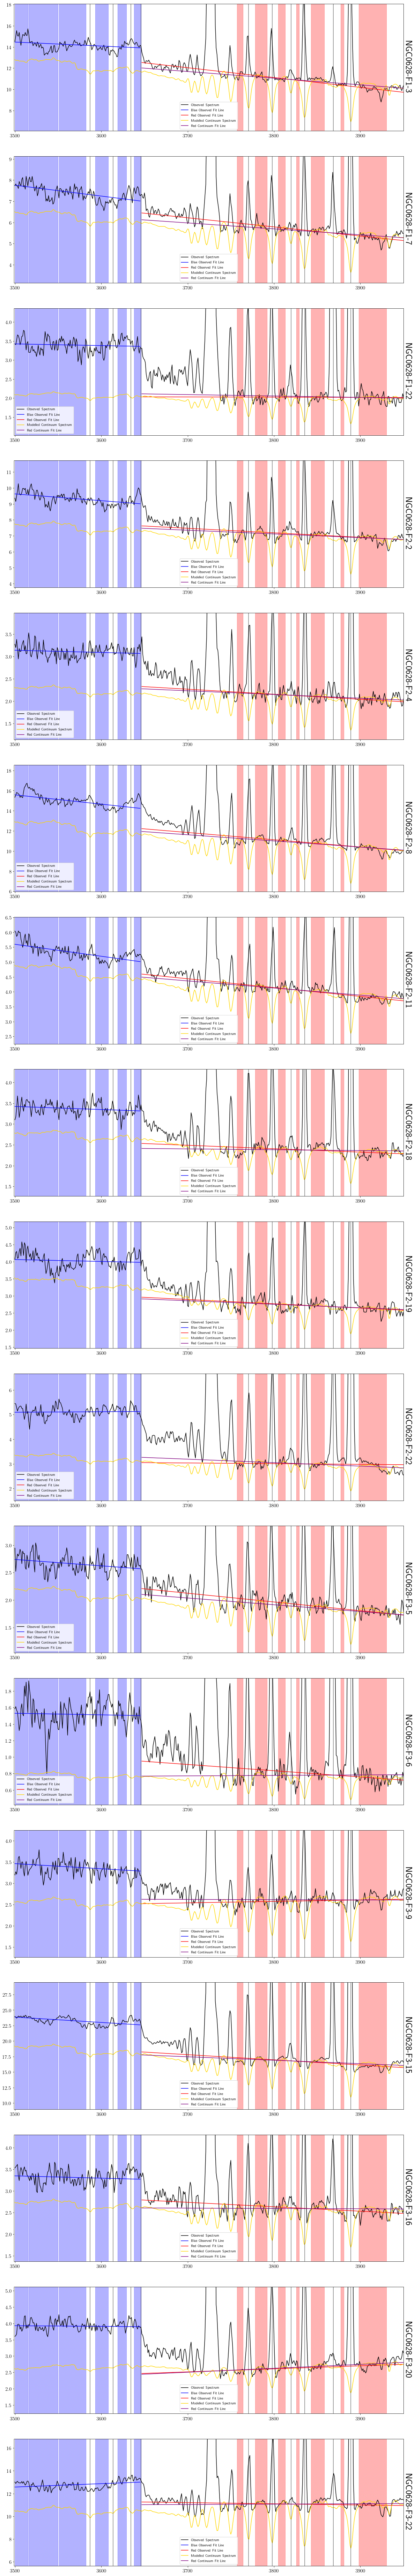

In [6]:
# Blue Line Fit Method: Regardless of method, we always measure the Blue side from the observed spectrum
plt.figure(figsize=(20,24*nn))

for i in range(0,nn):
    Region = regionName[i]
    BJDATA['Region'][i] = Region
    ObservedFile = observedFileName[i] 
    refitFile = refitFileName[i]

    #Pull Observed and Modelled Stellar Continuum - Find Nebular Spectrum by taking the difference and quadrature the errors
    wavelengthObs,   fluxObs,   errObs          = np.loadtxt(ObservedFile, unpack=True, usecols=(0,1,2))
    wavelengthCont, fluxCont, errCont, contCont = np.loadtxt(refitFile, unpack=True, usecols=(0,1,2,3))
    wavelengthNeb, fluxNeb, errNeb            = wavelengthCont[0:550], fluxObs[0:550]-contCont[0:550], (errObs[0:550]**2+errCont[0:550]**2)**(0.5)
        
    #set-up arrays to hold blue values, pulling only the values from the selected continuum windows
    blueMeasurements  = []
    bw  = []                    #list of wavelengths for blue line fit calculation
    bf  = []                    #list of fluxes      for blue line fit calculation
    be  = []                    #list of errors      for blue line fit calculation
 
    #assign the windows from original wavelength, flux, error arrays to the lists containing only the windows we want
    counter = 0
    boxi    = 0
    for box in blueBoxes:
        istart   = wavelengthObs.tolist().index(box[0]) 
        iend     = wavelengthObs.tolist().index(box[1]) + 1
        counter += box[1] - box[0] + 1  
        for k in range(istart,iend):
            bw.append(wavelengthObs[k])
            bf.append(fluxObs[k])
            be.append(errObs[k])
        boxi = boxi + 1    
    blueWavelength  = np.array(bw)              #turn lists of blue values into arrays for future manipulation
    blueFlux        = np.array(bf)
    blueErr         = np.array(be)

    
    # Begin MC line fit on blue side. We are going to do 1000 iterations.
    # We will populate the array with random gaussian noise taken from the errors on the data
    # If the difference between the first fit line and the spectrum is more than 2 sigma we will 
    # reassign the spectrum with the first fit line values at that wavelength to smooth out the 
    # noise before applying a final MC fit to the spectrum.
    
    for j in range(1000):
        blueSide  = []                      # holds the MC generated values for the blue side. 

        for n in range(len(blueFlux)):
            # Generate the MC fit using random gaussian noise.
            MCF = blueFlux[n] + (blueErr[n] * np.random.normal(loc=0.0, scale=1.0, size=None))
            blueSide.append(MCF)
    
        # Make the first line fit.
        slope, intercept, r_value, p_value, std_err = stats.linregress(blueWavelength, blueSide)
        blueFirstFit = slope * blueWavelength + intercept

        varianceBlue  = np.var(blueFirstFit[0:146])
        sigmaBlue = varianceBlue**(1/2)    
        
      
        # Check for big noise and smooth out spectrum with first fit.
        for k in range(len(blueSide)):
            if np.abs(blueSide[k] - blueFirstFit[k]) > (2 * sigmaBlue):
                blueSide[k] = blueFirstFit[k]                            
                
        # Reapply MC fitting to smoothed spectrum.
        slope, intercept, r_value, p_value, std_err = stats.linregress(blueWavelength, blueSide)
        blueFit = slope * wavelengthObs[0:146] + intercept

        # Pull value at 3643 Angstroms.
        blueMeasurements.append(blueFit[-4])   
        
        BJDATA['Blue'][i]          = np.average(blueMeasurements)
        BJDATA['BlueErr'][i]       = np.std(blueMeasurements)

        
# Red Line Obs Fit Method    
#set-up arrays to hold red values, pulling only the values from the selected continuum windows
    redMeasurementsObs = []
    rwObs = []                    #list of wavelengths for red line fit calculation
    rfObs = []                    #list of fluxes      for red line fit calculation
    reObs = []                    #list of errors      for red line fit calculation
    
    #assign the windows from original wavelength, flux, error arrays to the lists containing only the windows we want
    counter = 0
    boxi    = 0
    for box in redBoxes:
        istart   = wavelengthObs.tolist().index(box[0]) 
        iend     = wavelengthObs.tolist().index(box[1]) + 1
        counter += box[1] - box[0] + 1  
        for k in range(istart,iend):
            rwObs.append(wavelengthObs[k])
            rfObs.append(fluxObs[k])
            reObs.append(errObs[k])
        boxi = boxi + 1
    redWavelengthObs   = np.array(rwObs)              #turn lists of red values into arrays for future manipulation
    redFluxObs         = np.array(rfObs)
    redErrObs          = np.array(reObs)
    
    # Begin MC line fit on red side. We are going to do 1000 iterations.
    # We will populate the array with random gaussian noise taken from the errors on the data
    # If the difference between the first fit line and the spectrum is more than 2 sigma we will 
    # reassign the spectrum with the first fit line values at that wavelength to smooth out the 
    # noise before applying a final MC fit to the spectrum.
    
    for j in range(1000):
        redSideObs = []                      # holds the MC generated values for the red side. 

        for n in range(len(redFluxObs)):
            # Generate the MC fit using random gaussian noise.
            MCFObs = redFluxObs[n] + (redErrObs[n] * np.random.normal(loc=0.0, scale=1.0, size=None))
            redSideObs.append(MCFObs)
    
        # Make the first line fit.
        slopeObs, interceptObs, r_value, p_value, std_err = stats.linregress(redWavelengthObs, redSideObs)
        redFirstFitObs = slopeObs * redWavelengthObs + interceptObs
        varianceObs  = np.var(redFirstFitObs)
        sigmaRedObs = varianceObs**(1/2)   
        
        # Check for big noise and smooth out spectrum with first fit.
        for k in range(len(redSideObs)):
            if np.abs(redSideObs[k] - redFirstFitObs[k]) > (2 * sigmaRedObs):
                redSideObs[k] = redFirstFitObs[k]                            

        # Reapply MC fitting to smoothed spectrum.
        slopeObs, interceptObs, r_value, p_value, std_err = stats.linregress(redWavelengthObs, redSideObs)
        redFitLineObs = slopeObs * wavelengthObs + interceptObs

        # Pull value at 3681 Angstroms.
        redMeasurementsObs.append(redFitLineObs[181])    
        
        BJDATA['RedObs'][i]          = np.average(redMeasurementsObs)
        BJDATA['RedObsErr'][i]       = np.std(redMeasurementsObs)    
    
        # Calculate Unreddening corrected Jump value and its error.
        BJDATA['JumpObs'][i]         = BJDATA['Blue'][i] - BJDATA['RedObs'][i]
        BJDATA['JumpObsErr'][i]      = np.sqrt(BJDATA['BlueErr'][i]**2 + BJDATA['RedObsErr'][i]**2)

# Red Line Cont Fit Method    
#set-up arrays to hold red values, pulling only the values from the selected continuum windows
    redMeasurementsCont = []
    rwCont = []                    #list of wavelengths for red line fit calculation
    rfCont = []                    #list of fluxes      for red line fit calculation
    reCont = []                    #list of errors      for red line fit calculation
    
    #assign the windows from original wavelength, flux, error arrays to the lists containing only the windows we want
    counter = 0
    boxi    = 0
    for box in redBoxes:
        istart   = wavelengthObs.tolist().index(box[0]) 
        iend     = wavelengthObs.tolist().index(box[1]) + 1
        counter += box[1] - box[0] + 1  
        for k in range(istart,iend):
            rwCont.append(wavelengthCont[k])
            rfCont.append(contCont[k])
            reCont.append(errCont[k])
        boxi = boxi + 1
    redWavelengthCont   = np.array(rwCont)              #turn lists of red values into arrays for future manipulation
    redFluxCont         = np.array(rfCont)
    redErrCont          = np.array(reCont)
    
    # Begin MC line fit on red side. We are going to do 1000 iterations.
    # We will populate the array with random gaussian noise taken from the errors on the data
    # If the difference between the first fit line and the spectrum is more than 2 sigma we will 
    # reassign the spectrum with the first fit line values at that wavelength to smooth out the 
    # noise before applying a final MC fit to the spectrum.
    
    for j in range(1000):
        redSideCont = []                      # holds the MC generated values for the red side. 

        for n in range(len(redFluxCont)):
            # Generate the MC fit using random gaussian noise.
            MCFCont = redFluxCont[n] + (redErrCont[n] * np.random.normal(loc=0.0, scale=1.0, size=None))
            redSideCont.append(MCFCont)
    
        # Make the first line fit.
        slopeCont, interceptCont, r_value, p_value, std_err = stats.linregress(redWavelengthCont, redSideCont)
        redFirstFitCont = slopeCont * redWavelengthCont + interceptCont
        varianceCont  = np.var(redFirstFitCont)
        sigmaRedCont = varianceCont**(1/2)   
        
        # Check for big noise and smooth out spectrum with first fit.
        for k in range(len(redSideCont)):
            if np.abs(redSideCont[k] - redFirstFitCont[k]) > (2 * sigmaRedCont):
                redSideCont[k] = redFirstFitCont[k]                            

        # Reapply MC fitting to smoothed spectrum.
        slopeCont, interceptCont, r_value, p_value, std_err = stats.linregress(redWavelengthCont, redSideCont)
        redFitLineCont = slopeCont * wavelengthCont + interceptCont

        # Pull value at 3681 Angstroms.
        redMeasurementsCont.append(redFitLineCont[181])    
        
        BJDATA['RedCont'][i]          = np.average(redMeasurementsCont)
        BJDATA['RedContErr'][i]       = np.std(redMeasurementsCont)    
    
        # Calculate Unreddening corrected Jump value and its error.
        BJDATA['JumpCont'][i]         = BJDATA['Blue'][i] - BJDATA['RedCont'][i]
        BJDATA['JumpContErr'][i]      = np.sqrt(BJDATA['BlueErr'][i]**2 + BJDATA['RedContErr'][i]**2)
       
    # Determine best plotting parameters 
    wmin = wavelengthObs[0]
    wmax = 3900
    ymax = BJDATA['Blue'][i] * 1.3
    ymin = BJDATA['RedObs'][i] * 0.5
    
    # Make plots to show fit lines    
    plt.subplot(nn*3,1,i+1)
    plt.axis([3499, 3950,ymin,ymax])
    plt.plot(wavelengthObs,fluxObs,color='black', label = 'Observed Spectrum')
    plt.plot(wavelengthObs[0:146],blueFit[0:146],color='blue', label = 'Blue Observed Fit Line')
    plt.plot(wavelengthObs[147:997],redFitLineObs[147:997],color='red', label = 'Red Observed Fit Line')
    plt.plot(wavelengthCont,contCont,color='gold', label = 'Modelled Continuum Spectrum')
    plt.plot(wavelengthCont[147:1147],redFitLineCont[147:997],color='purple', label = 'Red Continuum Fit Line')
    plt.plot((3646.00, 3646.00),(ymin, ymax), "black", alpha = 0.5)
    plt.plot((3587.00, 3587.00),(ymin, ymax), "black", alpha = 0.5)
    plt.plot((3613.60, 3613.60),(ymin, ymax), "black", alpha = 0.5)
    plt.plot((3634.24, 3634.24),(ymin, ymax), "black", alpha = 0.5)
    plt.plot((3770.63, 3770.63),(ymin, ymax), "black", alpha = 0.5) 
    plt.plot((3797.90, 3797.90),(ymin, ymax), "black", alpha = 0.5)
    plt.plot((3819.61, 3819.61),(ymin, ymax), "black", alpha = 0.5)
    plt.plot((3835.39, 3835.39),(ymin, ymax), "black", alpha = 0.5)
    plt.plot((3868.75, 3868.75),(ymin, ymax), "black", alpha = 0.5)
    plt.plot((3889.05, 3889.05),(ymin, ymax), "black", alpha = 0.5)
    plt.text(3950,(ymax+ymin)/2, Region, fontsize=26,color='k',rotation=-90,va='center')
    boxiGoodRed = 0
    boxi = 0
    for box in redBoxes:
        plt.axvspan(box[0], box[1], alpha=0.3, color='red')
    for box in blueBoxes:
        plt.axvspan(box[0], box[1], alpha=0.3, color='blue')   
        boxi = boxi + 1    
    plt.legend(loc = 'best')
    
plt.savefig('LineFitsContvsObs.pdf')    

In [9]:
# Assign and print all data + flags for each spectrum to a txt file
np.set_printoptions(precision=4)

with open("rawJumpMeasurementDataAllWindows.txt", "w") as text_file:
    print('# If sample flag = 1: primary sample.', file=text_file)
    print('# If fit flag = 1: use JumpObs.', file=text_file)
    print('#Region  ','Blue   ','RedObs ', 'RedCont   ','JumpObs ','JumpCont ','BlueErr  ','RedObsErr  ', 'RedContErr', 'JumpObsErr','JumpContErr ', 'SampleFlag', 'FitFlag',file=text_file) 
    for i in range(0,nn):
        print(regionName[i],'{0:.4f}'.format(BJDATA['Blue'][i]),'{0:.4f}'.format(BJDATA['RedObs'][i]),'{0:.4f}'.format(BJDATA['RedCont'][i]),'{0:.4f}'.format(BJDATA['JumpObs'][i]),'{0:.4f}'.format(BJDATA['JumpCont'][i]),'{0:.4f}'.format(BJDATA['BlueErr'][i]),'{0:.4f}'.format(BJDATA['RedObsErr'][i]),'{0:.4f}'.format(BJDATA['RedContErr'][i]),'{0:.4f}'.format(BJDATA['JumpObsErr'][i]),'{0:.4f}'.format(BJDATA['JumpContErr'][i]),sampleFlags[i],fitFlags[i], file=text_file)        